In [7]:
# Tarvittavien kirjastojen tuonti
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

In [8]:
DATA_PATH = "../data/training.npz"

def load_data():
    data = np.load(DATA_PATH, allow_pickle=True)

    # Accessing the training and testing data
    X_train = data['X_train']
    y_train = data['y_train']
    X_test = data['X_test']
    y_test = data['y_test']
    labels = data['labels']
    
    return X_train, y_train, X_test, y_test, labels



X_train, y_train, X_test, y_test, labels = load_data()

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)
print("labels:", labels)


X_train: (1387, 64, 862)
y_train: (1387, 3)
X_test: (347, 64, 862)
y_test: (347, 3)
labels: ['fusku' 'salsa' 'valssi']


In [9]:
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras import saving
from tensorflow import keras


# Metric for model evaluation
@saving.register_keras_serializable()
def metric(y_true, y_pred):
    return K.mean(K.equal(K.argmax(y_true, axis=1), K.argmax(y_pred, axis=1)))


model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2], 1)),
    Conv2D(64, kernel_size=(4, 4), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 4)),
    Conv2D(32, (3, 5), activation='relu'
                    , kernel_regularizer=regularizers.l2(0.04)
                    ),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),
    Conv2D(32, (2, 2), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),
    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.04)),
    Dropout(0.5),
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.04)),
    Dense(y_train.shape[1], activation='softmax')
])


model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=[metric])

In [5]:
#visualize the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 61, 859, 64)    │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 61, 859, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 30, 214, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 210, 32)    │        30,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 105, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 105, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 13, 104, 32)    │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 13, 104, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 52, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 52, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9984)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       639,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 677,571 (2.58 MB)

 Trainable params: 677,379 (2.58 MB)

 Non-trainable params: 192 (768.00 B)

In [10]:
# Training the model
history = model.fit(X_train, y_train, epochs=25, validation_data=(X_test, y_test))

Epoch 1/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - loss: 9.5720 - metric: 0.4098 - val_loss: 9.2176 - val_metric: 0.4387
Epoch 2/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - loss: 5.6821 - metric: 0.4752 - val_loss: 4.0807 - val_metric: 0.6102
Epoch 3/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - loss: 3.8143 - metric: 0.5678 - val_loss: 3.3783 - val_metric: 0.5102
Epoch 4/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - loss: 2.6348 - metric: 0.6891 - val_loss: 2.2533 - val_metric: 0.6494
Epoch 5/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - loss: 1.9489 - metric: 0.7850 - val_loss: 1.6740 - val_metric: 0.7589
Epoch 6/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - loss: 1.5725 - metric: 0.7672 - val_loss: 1.4422 - val_metric: 0.6879
Epoch 7/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - loss: 1.2614 - metric: 0.8281 - val_loss: 1.3771 - val_metric: 0.7424
Epoch 8/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - loss: 1.0966 - metric: 0.8563 - val_loss: 1.1030 - val_metric: 0.7941
Epoch 9/25
44/44 ━━━━━

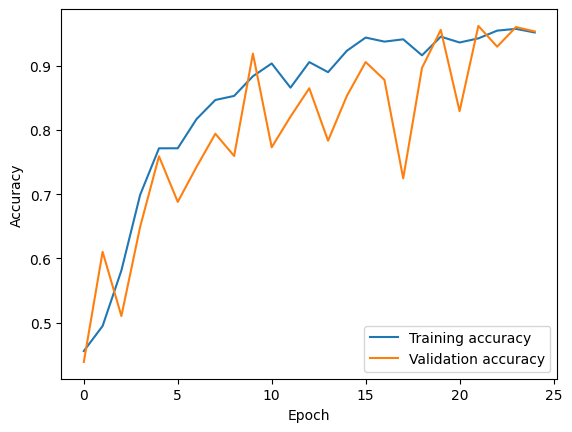

In [11]:
# Evaluating the model
plt.plot(history.history['metric'], label='Training accuracy')
plt.plot(history.history['val_metric'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [12]:
VALIDATION_DATA_PATH = "../data/validation.npz"

data = np.load(VALIDATION_DATA_PATH, allow_pickle=True)

X_val = data['X_val']
y_val = data['y_val']
labels = data['labels']

print("X_val:", X_val.shape)
print("y_val:", y_val.shape)
print("labels:", labels)

X_val: (98, 64, 862)
y_val: (98, 3)
labels: ['fusku' 'salsa' 'valssi']


4/4 - 1s - 187ms/step - loss: 0.7605 - metric: 0.8047
Model achieved 80.47% accyracy on the validation data.
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step
True Real: salsa, Predicted: salsa, Confidence: 1.00
True Real: salsa, Predicted: salsa, Confidence: 1.00
True Real: salsa, Predicted: salsa, Confidence: 1.00
True Real: salsa, Predicted: salsa, Confidence: 0.99
True Real: salsa, Predicted: salsa, Confidence: 0.75
True Real: salsa, Predicted: salsa, Confidence: 1.00
True Real: salsa, Predicted: salsa, Confidence: 0.97
True Real: salsa, Predicted: salsa, Confidence: 1.00
True Real: salsa, Predicted: salsa, Confidence: 1.00
True Real: salsa, Predicted: salsa, Confidence: 1.00
True Real: salsa, Predicted: salsa, Confidence: 1.00
True Real: salsa, Predicted: salsa, Confidence: 0.99
True Real: salsa, Predicted: salsa, Confidence: 1.00
True Real: salsa, Predicted: salsa, Confidence: 0.72
True Real: salsa, Predicted: salsa, Confidence: 1.00
False Real: salsa, Predicted: valssi, Confidence: 0.81
Tr

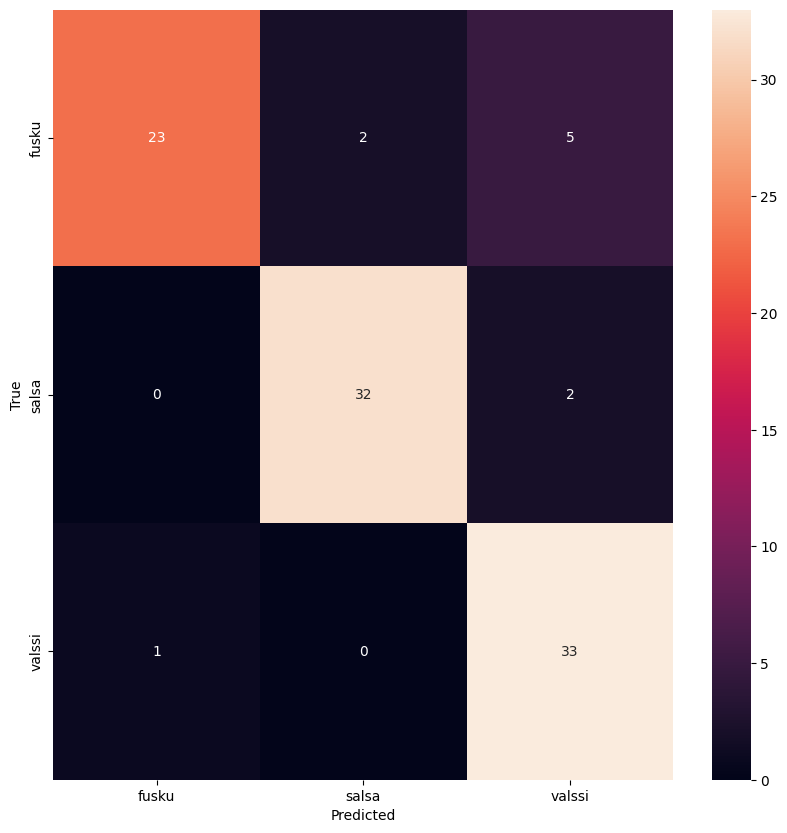

In [13]:

from tensorflow.keras.models import load_model

#load the trained model
#model = load_model('model_3_genres_best.keras')

#evaluate the model on the validation data
test_loss, test_acc = model.evaluate(X_val, y_val, verbose=2)
print(f'Model achieved {test_acc*100:.2f}% accuracy on the validation data.')    

#predict the labels for the validation data
predicted_labels_one_hot = model.predict(X_val)
indices = np.argmax(predicted_labels_one_hot, axis=1)
predicted_labels = labels[indices]

true_labels = labels[np.argmax(y_val, axis=1)]

# Get the confidence (probability) of the predicted class
predicted_confidence = np.max(predicted_labels_one_hot, axis=1)

# Print the true and predicted labels
for i in range(len(predicted_labels)):
    prediction_true = true_labels[i] == predicted_labels[i]
    print(f'{prediction_true} Real: {true_labels[i]}, Predicted: {predicted_labels[i]}, Confidence: {predicted_confidence[i]:.2f}')

#plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_labels, predicted_labels, labels=labels)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [15]:
# save the model whit the best accuracy
model.save(f'model_3_genres_best_{test_acc:.2f}.keras')
print('Model saved.')

Model saved.
